# Multiple Objects Detection and Classification

The notebook illustrates how the SquiDS package can help to create and test multiple objects detection and classification model.

**Please note that the goal of this notebook is not to create the perfect ML model, but to demonstrate how to use the functionality of the SquiDS package.**

In [2]:
import sys
sys.path.insert(0, '..')

from PIL import ImageDraw, ImageFont
import tensorflow as tf
import numpy as np
from hungarian_loss import hungarian_loss

from squids import (
    create_dataset,
    create_tfrecords,
    explore_tfrecords,
    load_tfrecords,
    Palette,
    Background
)

from helper import plot_images

## Preparing Dataset

Generate synthetic dataset and convert it to TFRecords.

In [3]:
create_dataset(
    dataset_size=10000,
    image_palette=Palette.BINARY,
    image_background=Background.BLACK,
    random_state=365,
    image_capacity=2,
    verbose=True)
create_tfrecords(verbose=True)

100%|██████████| 996/996 [00:01<00:00, 714.92it/s]


Explore few samples from the generated dataset.

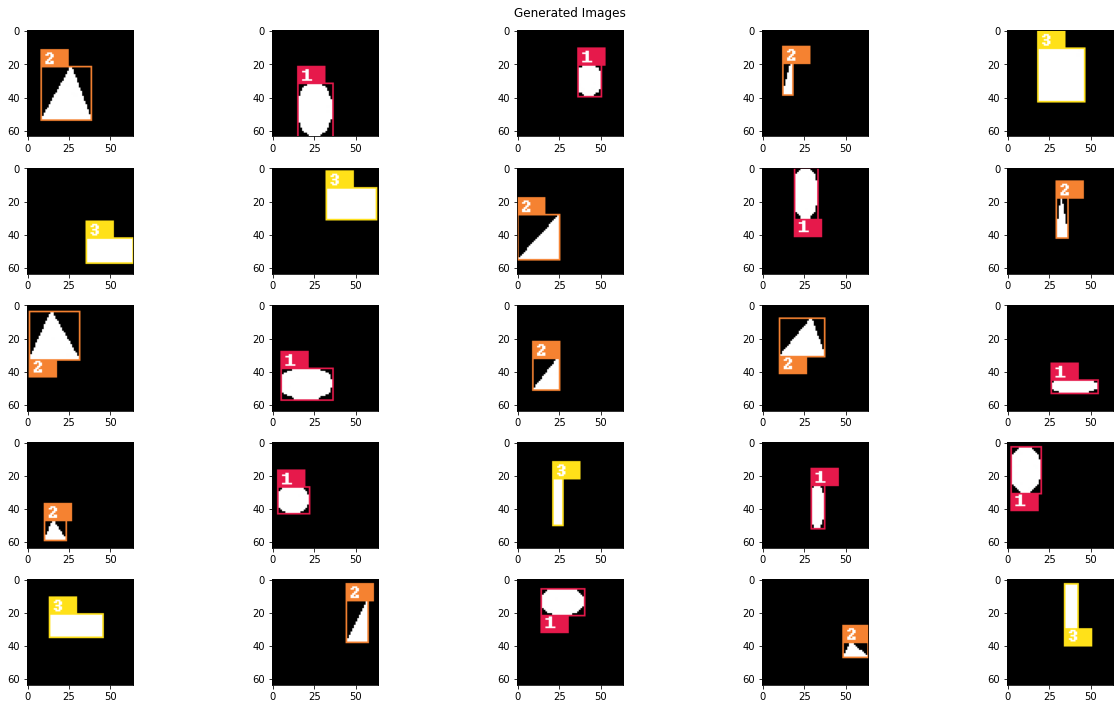

In [3]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_train',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_train',
        image_id,
        with_categories=True,
        with_bboxes=True,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Generated Images")

## Train Object Detection Model

Let's create generators for train and validation datasets and compute steps per epoch for each of them. 

Note:
1. For this model we need to combine bounding boxes and categories one-hot encodings. We can do it by using the `BC` output schema.
2. The number of detecting objects is 2.


In [4]:
ds_train, train_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_train", 
    output_schema = "BC",
    num_detecting_objects=2,
)
print(
    "Training steps per epoch (for the default batch size 32):",
    train_steps_per_epoch
)

ds_val, val_steps_per_epoch = load_tfrecords(
    "dataset/synthetic-tfrecords/instances_val", 
    output_schema = "BC",
    num_detecting_objects=2,
)
print(
    "Validation steps per epoch (for the default batch size 32):",
    val_steps_per_epoch
)

Training steps per epoch (for the default batch size 32): 55
Validation steps per epoch (for the default batch size 32): 17


Let's define a simple convolution model.

In [6]:
localizer = tf.keras.models.Sequential([
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu',
        input_shape=(1024,)),
	tf.keras.layers.Dense(2 * 4),
	tf.keras.layers.Reshape((2, 4))
])

classifier = tf.keras.models.Sequential([
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu',
        input_shape=(1024,)),
	tf.keras.layers.Dense(2 * 4),
	tf.keras.layers.Reshape((2, 4)),
	tf.keras.layers.Softmax(),
	tf.keras.layers.Lambda(lambda x: x * 10)
])

common = tf.keras.models.Sequential([
	tf.keras.layers.Conv2D(
			filters=32,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=64,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=128,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Conv2D(
			filters=256,
            kernel_size=(3, 3),
            padding='same',
            input_shape=(64, 64, 3)),
    tf.keras.layers.MaxPooling2D(
            pool_size=(2, 2)),
	tf.keras.layers.Flatten(),
	tf.keras.layers.Dense(
		1024, 
		kernel_initializer='random_normal',
		bias_initializer='zeros',
		activation='relu'),
])

model_input = common.input
x = common(model_input)
model_output = tf.keras.layers.Concatenate()(
	[localizer(x), classifier(x)])
model = tf.keras.models.Model(model_input, model_output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=hungarian_loss,
)

Now we are ready to perform the model training. Note that the best model weights are stored in the `best_weights.h5` file.

In [7]:

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_weights.h5",
    monitor='val_loss',
    mode="min",
    save_best_only=True,
    verbose=1)
model.fit(
    ds_train,
    steps_per_epoch = train_steps_per_epoch,
    epochs=50,
    validation_data=ds_val,
    validation_steps = val_steps_per_epoch,
    callbacks=checkpoint_callback,
    verbose=1
)

Epoch 1/50


2022-02-20 21:45:31.468175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-02-20 21:45:33.152332: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


55/55 [==============================] - ETA: 0s - loss: 10.1568
Epoch 1: val_loss improved from inf to 7.20056, saving model to best_weights.h5
55/55 [==============================] - 37s 544ms/step - loss: 10.1568 - val_loss: 7.2006
Epoch 2/50
55/55 [==============================] - ETA: 0s - loss: 6.4199
Epoch 2: val_loss improved from 7.20056 to 5.44082, saving model to best_weights.h5
55/55 [==============================] - 30s 540ms/step - loss: 6.4199 - val_loss: 5.4408
Epoch 3/50
55/55 [==============================] - ETA: 0s - loss: 5.1318
Epoch 3: val_loss improved from 5.44082 to 4.82683, saving model to best_weights.h5
55/55 [==============================] - 30s 537ms/step - loss: 5.1318 - val_loss: 4.8268
Epoch 4/50
55/55 [==============================] - ETA: 0s - loss: 4.5195
Epoch 4: val_loss improved from 4.82683 to 4.32039, saving model to best_weights.h5
55/55 [==============================] - 29s 535ms/step - loss: 4.5195 - val_loss: 4.3204
Epoch 5/50
55/55 

## Test Object Detection Model

Let's test the model on the unseen data.

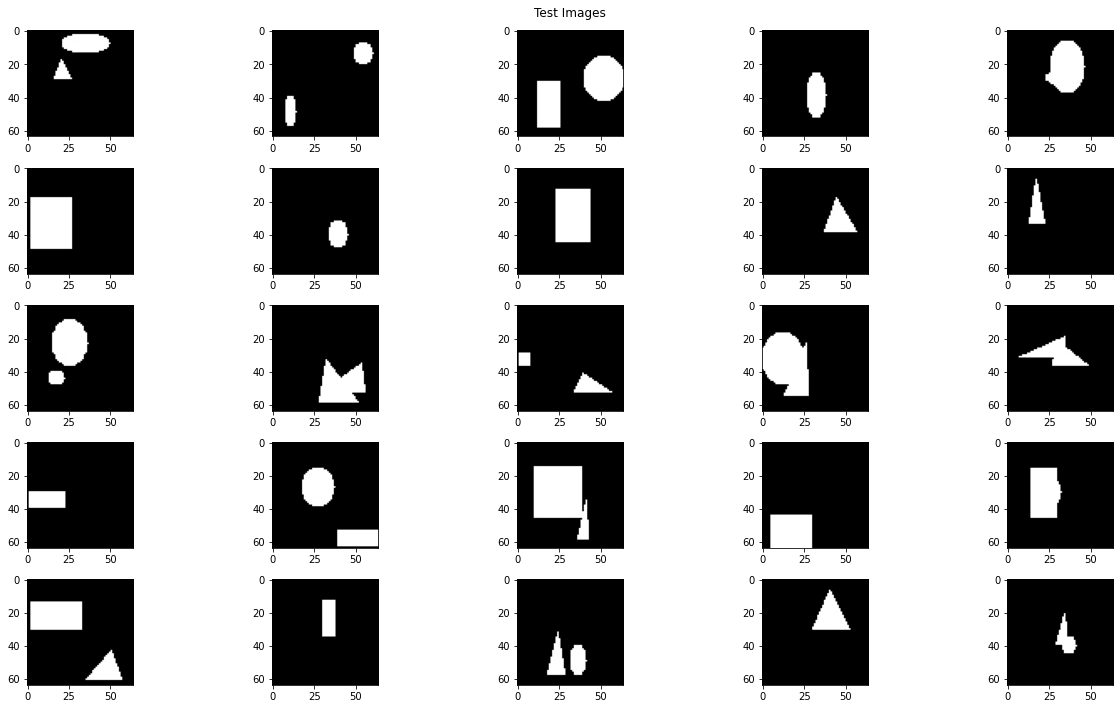

In [11]:
image_ids, _ = explore_tfrecords(
    'dataset/synthetic-tfrecords/instances_test',
    return_artifacts=True
)

images  = [
    explore_tfrecords(
        'dataset/synthetic-tfrecords/instances_test',
        image_id,
        return_artifacts=True
    )[0]
    for image_id in image_ids[0:25]
]

plot_images(images, "Test Images")

Make model prediction and overlay results on the test images.

Categories ID:
- 0 - Ellipse;
- 1 - Triangle;
- 2 - Rectangle;

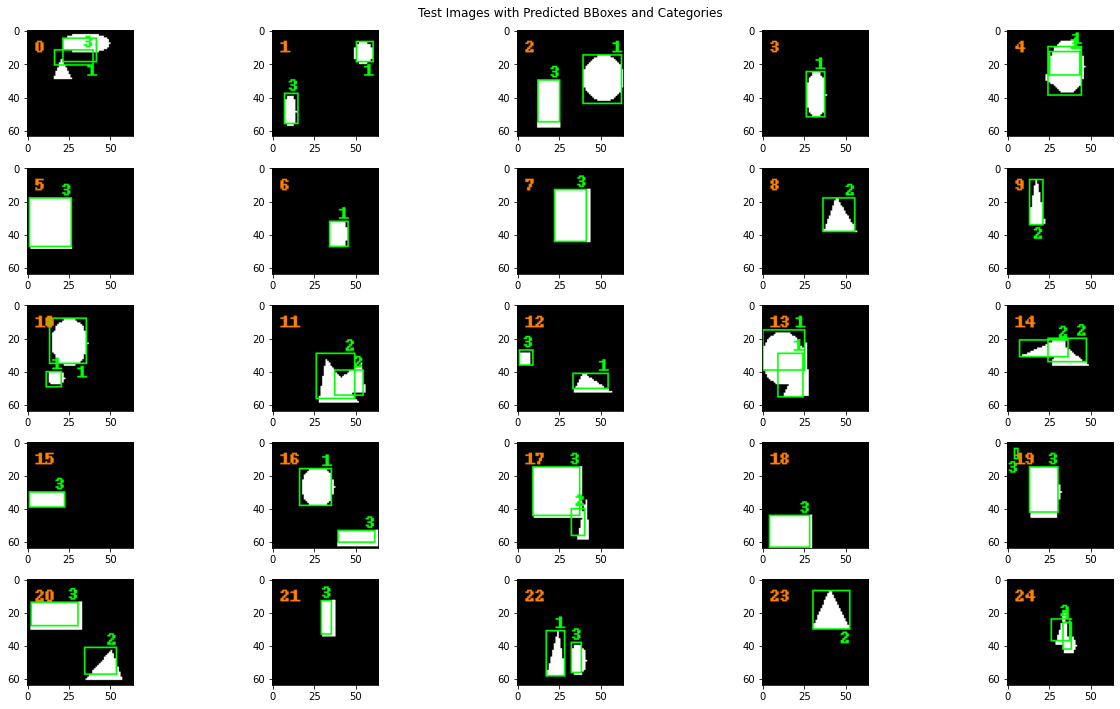

In [12]:
preprocessed_images = np.array(
    [np.array(image) for image in images]
) / 255.0

model.load_weights("best_weights.h5")
predictions = model.predict(preprocessed_images)

sample = 0
for image, prediction in zip(images, predictions):
    draw = ImageDraw.Draw(image)
    for detection in prediction:
        draw = ImageDraw.Draw(image)
        bbox = detection[:4].astype(int)
        category_id = np.argmax(detection[4:])
        if category_id > 0:
            x, y, w, h = bbox
            draw.rectangle(
                (x, y, x + w, y + h),
                outline="#00FF00"
            )
            if bbox[1] < 10:
                draw.text(
                    (x + w - 5, y + h),
                    str(category_id),
                    "#00FF00",
                    font=ImageFont.load_default(),
                )
            else:
                draw.text(
                    (x + w - 5, y - 10),
                    str(category_id),
                    "#00FF00",
                    font=ImageFont.load_default(),
                )
    draw.text(
        (5,5),
        str(sample),
        "#FF8000",
        font=ImageFont.load_default(),
    )
    sample += 1

plot_images(images, "Test Images with Predicted BBoxes and Categories")